In [1]:
import os
import glob
import time
import functools
import multiprocessing

from tqdm.notebook import tqdm
from tqdm.contrib.concurrent import process_map
from numba import njit
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
path_data = os.path.join(os.getcwd(), 'data')

data_folders = os.listdir(path_data)

path_images = []

for df in data_folders:
    
    pf = os.path.join(path_data, df, df, '*.png')
    path_images += glob.glob(pf)
    

In [3]:
@njit
def bilateral_filter(
    image: np.ndarray, 
    kernel_size: int,
    sigma_domain_kernel: float,
    sigma_range_kernel: float
) -> np.ndarray:
    """
    """
    height, width, channels = image.shape
    half_size = kernel_size // 2
    image_filtered = np.zeros(image.shape, dtype=image.dtype)
    sigma_dk = 2 * np.square(sigma_domain_kernel)
    sigma_rk = 2 * np.square(sigma_range_kernel)
    
    for i in range(height):
        for j in range(width):
            
            num = np.zeros(channels)
            denom = 0.0
                
            for k in range(max(0, i - half_size), min(height, i + half_size + 1)):
                for l in range(max(0, j - half_size), min(width, j + half_size + 1)):

                    t1 = domain_kernel(i, j, k, l, sigma_dk)
                    t2 = range_kernel(image[i, j], image[k, l], sigma_rk)
                    
                    weight = np.exp(t1 + t2)
                    
                    num += image[k, l] * weight
                    denom += weight

            image_filtered[i, j] = num / denom
                    
    return image_filtered.astype(np.uint8)


#@njit
def bilateral_filter_row(
    row: int,
    image: np.ndarray, 
    kernel_size: int,
    sigma_domain_kernel: float,
    sigma_range_kernel: float
) -> np.ndarray:
    """
    """
    height, width, channels = image.shape
    half_size = kernel_size // 2
    image_filtered = np.zeros((1, width, channels), dtype=image.dtype)
    sigma_dk = 2 * np.square(sigma_domain_kernel)
    sigma_rk = 2 * np.square(sigma_range_kernel)
    
    for j in range(width):

        num = np.zeros(channels)
        denom = 0.0

        for k in range(max(0, row - half_size), min(height, row + half_size + 1)):
            for l in range(max(0, j - half_size), min(width, j + half_size + 1)):

                t1 = domain_kernel(row, j, k, l, sigma_dk)
                t2 = range_kernel(image[row, j], image[k, l], sigma_rk)

                weight = np.exp(t1 + t2)

                num += image[k, l] * weight
                denom += weight

        image_filtered[0, j] = num / denom
                    
    return image_filtered.astype(np.uint8)
                    

@njit
def domain_kernel(i: int, j: int, k: int, l: int, sigma_dk: float) -> float:
    """Computes the differences of coordinates for the domain kernel.
    
    Args:
        i, j: coordinate of the central pixel of the kernel
        k, l: coordinate of a local neighbor for the central pixel
        sigma_dk: 2 * square of sigma domain kernel
        
    Returns:
        value of coordinate difference
    """
    return - (np.square(i - k) + np.square(j - l)) / sigma_dk


@njit
def range_kernel(pixel1: np.ndarray, pixel2: np.ndarray, sigma_rk: float) -> float:
    """Computes the squared L2 norm of pixel intensity differences
    for the range kernel.

    Args:
        pixel1: central pixel of the kernel
        pixel2: local neighbor of the central pixel under the smoothing kernel
        sigma_rk: 2 * square of sigma range kernel

    Returns:
        value of pixel intensity difference
    """
    return - np.square(np.linalg.norm(np.subtract(pixel1, pixel2))) / sigma_rk

Image shape: (512, 512, 3)


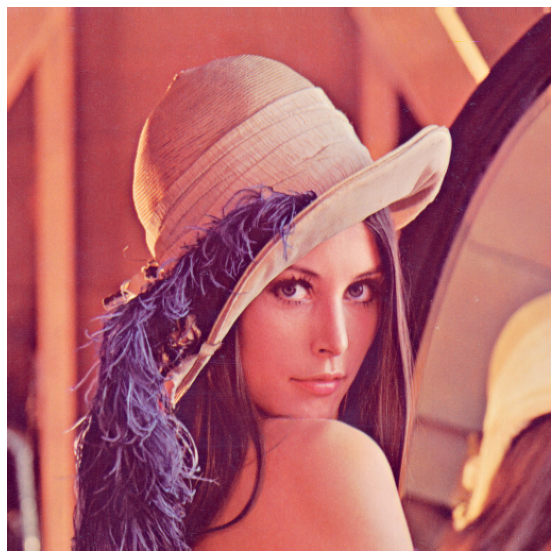

In [4]:
img = cv2.imread('lenna.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
height, width, channels = img.shape

print(f'Image shape: {img.shape}')

fig = plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(img)

Elapsed 113.50 seconds


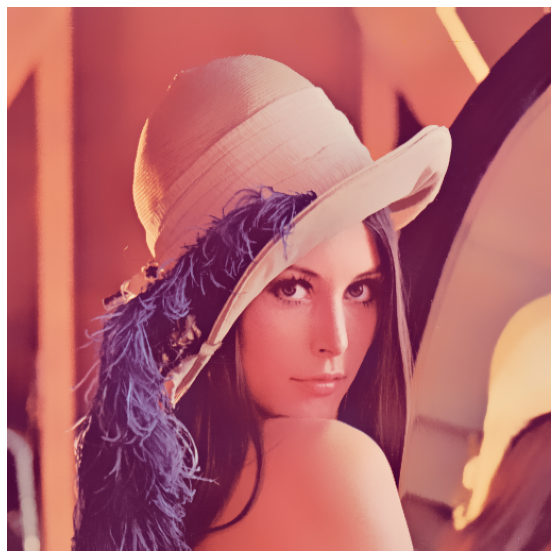

In [6]:
window_size = 31
sigma_dk = 23
sigma_rk = 23

start = time.time()

img_filtered = bilateral_filter(img.astype(float), window_size, sigma_dk, sigma_rk)

print(f'Elapsed {(time.time() - start):.2f} seconds')

fig = plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(img_filtered)

In [ ]:
n_processes = 4

func = functools.partial(
    bilateral_filter_row, 
    image=img.astype(float), 
    kernel_size=window_size, 
    sigma_domain_kernel=sigma_dk, 
    sigma_range_kernel=sigma_rk
)


with multiprocessing.Pool(processes=n_processes) as pool:
    
    res = pool.map(func, list(range(height)))

In [19]:
path_results = os.path.join(os.getcwd(), 'results')

if not os.path.isdir(path_results):
    
    os.mkdir(path_results)

In [23]:
window_size = 31

domain_sigmas = [1, 6, 12, 15]
range_sigmas = [1, 6, 12, 15]

param_grid = [[window_size, i, j] for i in domain_sigmas for j in range_sigmas]

start = 

images_filtered = 

In [24]:
param_grid

[[31, 1, 1],
 [31, 1, 6],
 [31, 1, 12],
 [31, 1, 15],
 [31, 6, 1],
 [31, 6, 6],
 [31, 6, 12],
 [31, 6, 15],
 [31, 12, 1],
 [31, 12, 6],
 [31, 12, 12],
 [31, 12, 15],
 [31, 15, 1],
 [31, 15, 6],
 [31, 15, 12],
 [31, 15, 15]]

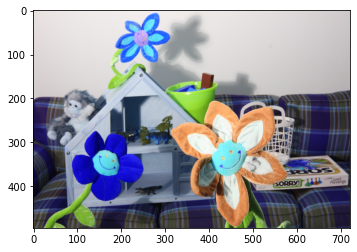

In [29]:
img = cv2.imread(path_images[0])
h, w, c = img.shape

img = cv2.resize(img, (w // 4, h // 4))

plt.imshow(img)

In [32]:
img_filtered = bilateral_filter(img.astype(float), 15, 33, 33)

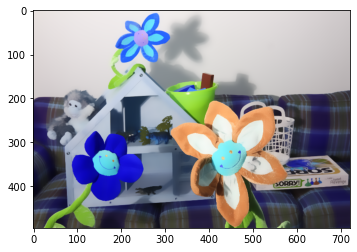

In [33]:
plt.imshow(img_filtered)

In [232]:
img

array([[[233, 226, 223],
        [232, 226, 223],
        [232, 226, 223],
        ...,
        [208, 202, 203],
        [207, 201, 202],
        [206, 201, 201]],

       [[234, 227, 224],
        [233, 226, 223],
        [233, 226, 223],
        ...,
        [207, 200, 202],
        [206, 201, 201],
        [207, 201, 202]],

       [[232, 226, 223],
        [233, 226, 223],
        [233, 226, 223],
        ...,
        [207, 201, 201],
        [206, 200, 201],
        [206, 200, 201]],

       ...,

       [[ 68,  67,  49],
        [ 74,  68,  53],
        [ 70,  54,  40],
        ...,
        [ 36,  38,  79],
        [ 35,  37,  78],
        [ 34,  36,  78]],

       [[ 71,  67,  53],
        [ 74,  66,  51],
        [ 63,  50,  36],
        ...,
        [ 34,  38,  77],
        [ 36,  37,  77],
        [ 35,  36,  79]],

       [[ 76,  69,  52],
        [ 76,  61,  45],
        [ 65,  49,  34],
        ...,
        [ 35,  37,  77],
        [ 37,  38,  78],
        [ 33,  34,  78]]

In [233]:
img_filtered

array([[[233, 226, 223],
        [233, 226, 223],
        [233, 226, 223],
        ...,
        [207, 201, 201],
        [207, 201, 202],
        [206, 201, 201]],

       [[233, 226, 223],
        [233, 226, 223],
        [233, 226, 223],
        ...,
        [206, 201, 201],
        [206, 201, 202],
        [206, 201, 202]],

       [[233, 226, 223],
        [233, 226, 223],
        [233, 226, 223],
        ...,
        [206, 201, 201],
        [206, 201, 201],
        [206, 201, 201]],

       ...,

       [[ 72,  66,  49],
        [ 73,  66,  50],
        [ 69,  54,  43],
        ...,
        [ 36,  37,  78],
        [ 35,  37,  78],
        [ 35,  36,  79]],

       [[ 73,  67,  51],
        [ 73,  65,  50],
        [ 66,  50,  39],
        ...,
        [ 35,  37,  78],
        [ 35,  37,  78],
        [ 35,  36,  78]],

       [[ 74,  67,  51],
        [ 74,  62,  49],
        [ 65,  50,  37],
        ...,
        [ 35,  37,  77],
        [ 35,  37,  78],
        [ 35,  36,  78]]

In [202]:
import numba

In [203]:
numba.__version__

'0.53.1'

In [197]:
a = []

for i in range(9):
    
    a.append(img[i, 0])

In [161]:
a

[array([233, 226, 223], dtype=uint8),
 array([234, 227, 224], dtype=uint8),
 array([232, 226, 223], dtype=uint8),
 array([233, 226, 223], dtype=uint8),
 array([233, 226, 223], dtype=uint8),
 array([233, 226, 223], dtype=uint8),
 array([232, 225, 223], dtype=uint8),
 array([232, 225, 222], dtype=uint8),
 array([232, 225, 224], dtype=uint8)]

In [185]:
np.array(a).shape

(9, 3)

In [186]:
np.sum(a, axis=0)

array([2094, 2032, 2008], dtype=uint32)

In [199]:
np.stack(a).shape

(9, 3)

In [205]:
np.asarray(a).shape

(9, 3)

In [220]:
img[0, 0]

array([233, 226, 223], dtype=uint8)

In [224]:
img[0, 5]

array([234, 227, 224], dtype=uint8)

In [225]:
np.subtract(img[0, 0], img[0, 5])

array([255, 255, 255], dtype=uint8)

In [226]:
np.linalg.norm(np.subtract(img[0, 0], img[0, 5]))

441.6729559300637

In [227]:
np.sqrt(255**2 + 255**2 + 255**2)

441.6729559300637

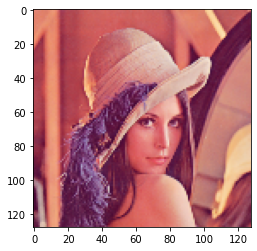

In [34]:
img = cv2.imread('lenna.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h, w, c = img.shape

img = cv2.resize(img, (w // 4, h // 4))

plt.imshow(img)

In [35]:
img_filtered = bilateral_filter(img.astype(float), 11, 23, 23)

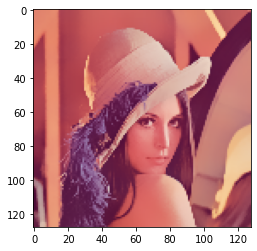

In [36]:
plt.imshow(img_filtered)

In [10]:
@njit
def test_func(image):
    
    a = ()
    
    for i in range(9):
        
        a = (*a, image[i, 0])
    
    
    
    return a

In [11]:
test_func(img.astype(float))

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mCannot unify Tuple() and UniTuple(array(float64, 1d, C) x 1) for 'a.2', defined at <ipython-input-10-913581bcbdce> (6)
[1m
File "<ipython-input-10-913581bcbdce>", line 6:[0m
[1mdef test_func(image):
    <source elided>
    
[1m    for i in range(9):
[0m    [1m^[0m[0m
[0m
[0m[1mDuring: typing of assignment at <ipython-input-10-913581bcbdce> (6)[0m
[1m
File "<ipython-input-10-913581bcbdce>", line 6:[0m
[1mdef test_func(image):
    <source elided>
    
[1m    for i in range(9):
[0m    [1m^[0m[0m


In [4]:
type(())

tuple

In [37]:
np.concatenate((np.array([]), np.random.normal(1, 3)), axis=0)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 0 dimension(s)

In [39]:
list(img[0, 0])

[225, 137, 129]

In [42]:
img[0, 0].tolist()

[225, 137, 129]

In [12]:
a = np.zeros(3)

In [13]:
a

array([0., 0., 0.])

In [14]:
a += np.ones(3)

In [15]:
a

array([1., 1., 1.])